In [39]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# TensorFlow / Keras Imports
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Bidirectional,
    TimeDistributed, Dense, Flatten, Dropout, BatchNormalization, Reshape
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Preprocessing

In [40]:
df = pd.read_csv("data.csv")

In [41]:
df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
df.set_index("ts", inplace=True)  # Set timestamp as index

/tmp/ipykernel_174308/3326812862.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df.resample("M").mean()  # Change "W" to "M" for monthly


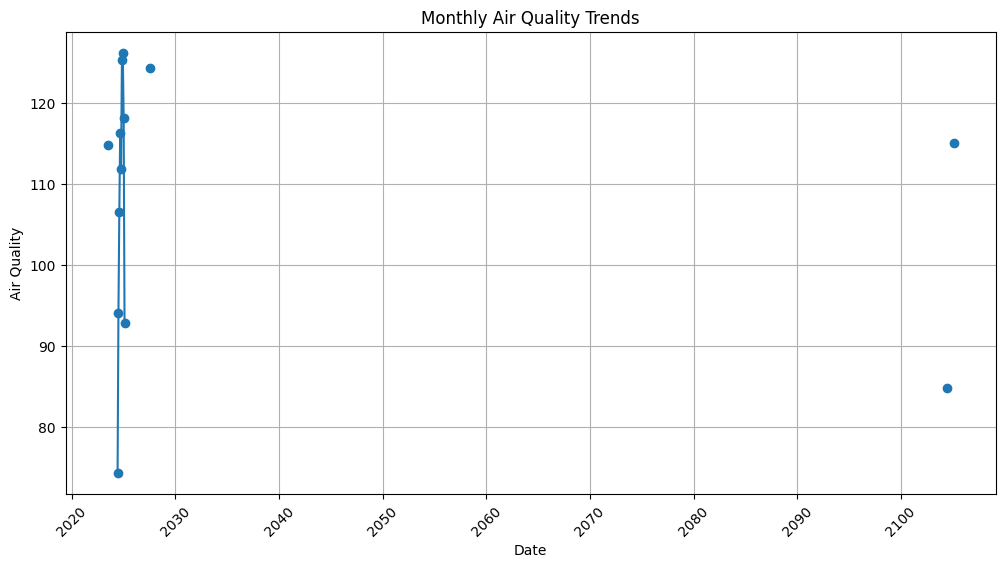

In [42]:
import pandas as pd
import matplotlib.pyplot as plt  

# Resample weekly or monthly (choose based on requirement)
df_resampled = df.resample("M").mean()  # Change "W" to "M" for monthly

plt.figure(figsize=(12, 6))  
plt.plot(df_resampled.index, df_resampled["Air Quality"], marker="o", linestyle="-")  
plt.xlabel("Date")  
plt.ylabel("Air Quality")  
plt.title("Monthly Air Quality Trends")  
plt.xticks(rotation=45)  
plt.grid()  
plt.show()  


In [43]:
df = df[(df.index < "2026-01-01") & (df.index > "2024-01-01")]


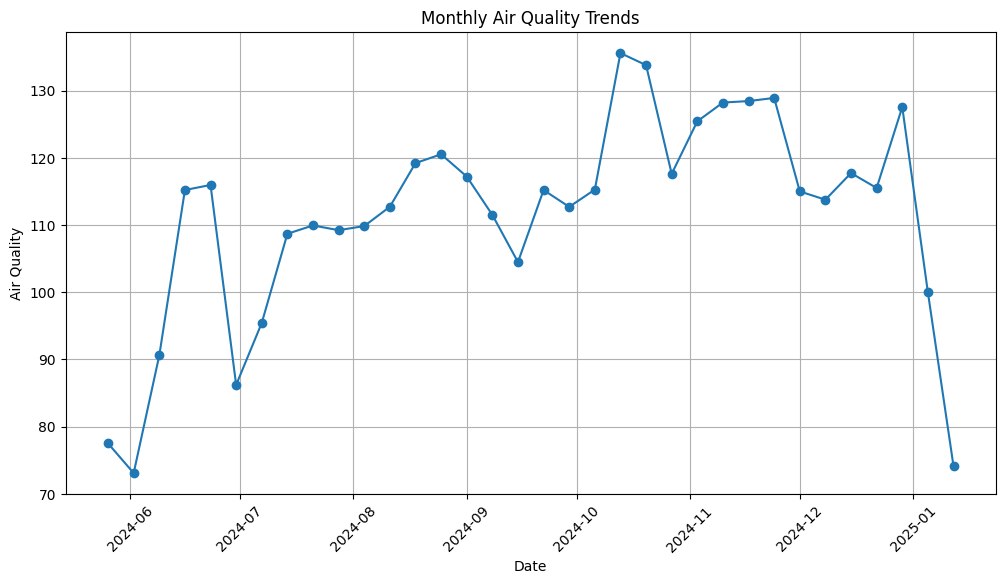

In [44]:
df_resampled = df.resample("W").mean()  # Change "W" to "M" for monthly

plt.figure(figsize=(12, 6))  
plt.plot(df_resampled.index, df_resampled["Air Quality"], marker="o", linestyle="-")  
plt.xlabel("Date")  
plt.ylabel("Air Quality")  
plt.title("Monthly Air Quality Trends")  
plt.xticks(rotation=45)  
plt.grid()  
plt.show()  

In [45]:
# Create a copy of the dataframe
df2 = df.copy()
df2.shape

(589168, 10)

In [46]:
df2['month'] = df2.index.month


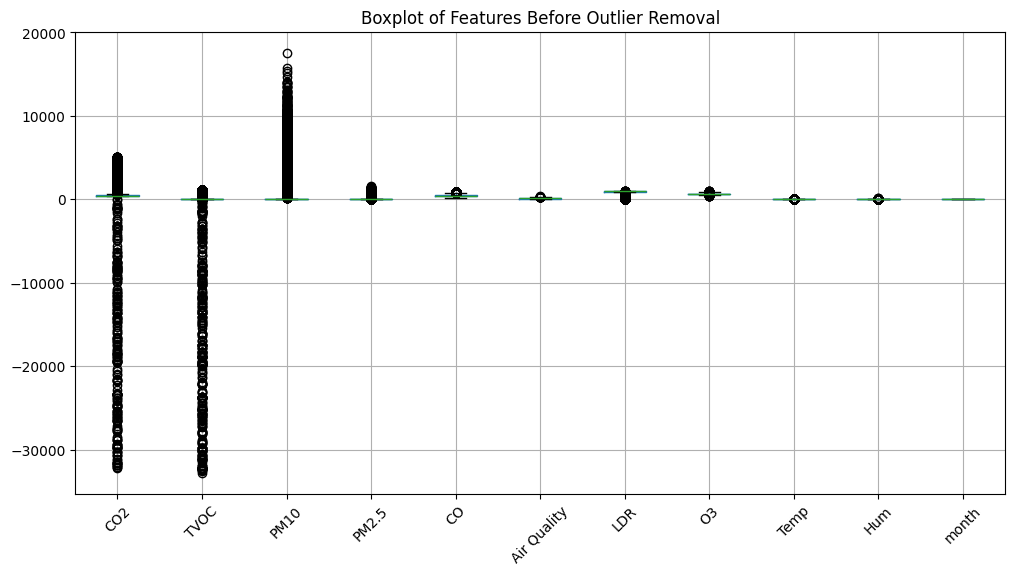

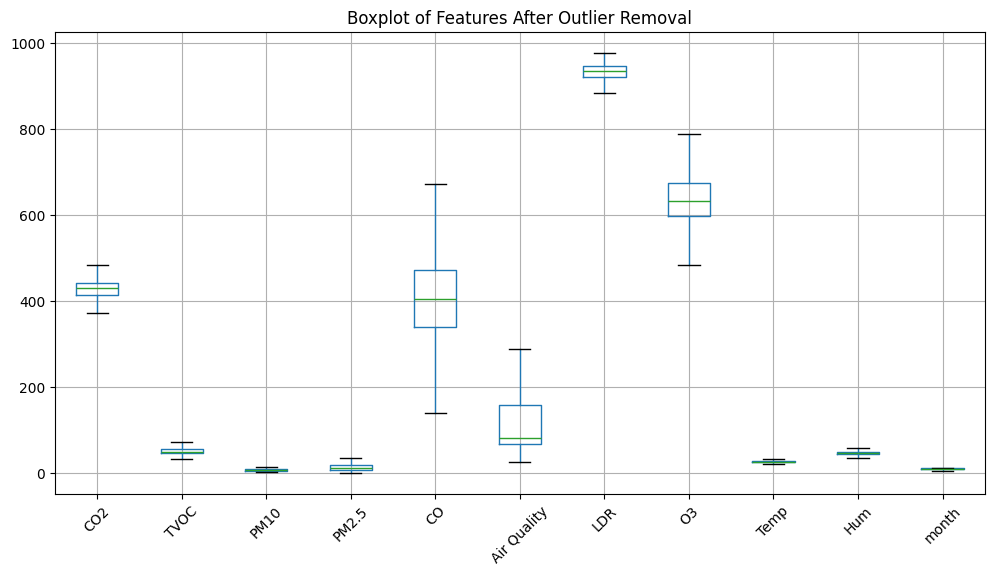

In [47]:
df2_original = df2.copy()

# Get numerical columns list
num_cols = df2.select_dtypes(include=[np.number]).columns.tolist()

# Plot the boxplot of the original data (with outliers)
plt.figure(figsize=(12, 6))
df2_original[num_cols].boxplot(rot=45)
plt.title("Boxplot of Features Before Outlier Removal")
plt.show()

# ------------------------------------------------
# Now, remove outliers from df2 and plot again if needed

# Initialize a variable to track the number of rows (for reference)
previous_rows = df2.shape[0]

while True:
    # Calculate Q1, Q3, and IQR for numerical columns
    Q1 = df2[num_cols].quantile(0.25)
    Q3 = df2[num_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Determine outlier condition for each cell
    outliers = ((df2[num_cols] < (Q1 - 1.5 * IQR)) | (df2[num_cols] > (Q3 + 1.5 * IQR)))

    # Remove rows with any outliers
    new_df2 = df2[~outliers.any(axis=1)]

    # Check if no rows were removed
    current_rows = new_df2.shape[0]
    if current_rows == previous_rows:
        break  # Stop the loop if no more outliers were removed

    # Update df2 and previous_rows for the next iteration
    df2 = new_df2.copy()
    previous_rows = current_rows

# Optionally, plot the cleaned data boxplot
plt.figure(figsize=(12, 6))
df2[num_cols].boxplot(rot=45)
plt.title("Boxplot of Features After Outlier Removal")
plt.show()


In [48]:
def categorize_air_quality(value):
    if value <= 50:
        return 'Good'
    elif 51 <= value <= 100:
        return 'Moderate'
    elif 101 <= value <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif 151 <= value <= 200:
        return 'Unhealthy'
    else:
        return 'Hazardous'
    
df2['Air Quality'] = df2['Air Quality'].apply(categorize_air_quality)

In [49]:
def scale_features(data, scaler=None):
    """
    Scales features using StandardScaler. If a scaler is provided, it transforms the data;
    otherwise, it fits and transforms the data using a new StandardScaler instance.
    
    Parameters:
    X_train (array-like): Feature matrix.
    scaler (StandardScaler, optional): Pre-fitted StandardScaler instance. Defaults to None.
    
    Returns:
    X_train_scaled (np.array): Scaled feature matrix.
    scaler (StandardScaler): StandardScaler instance used.
    """
    if scaler is None:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
    else:
        data_scaled = scaler.transform(data)
    
    return data_scaled, scaler

In [50]:

def encode_labels(y):
    """
    Encodes categorical labels into integers and ensures a 1D array.
    
    Parameters:
    y_train (array-like): Original labels.
    
    Returns:
    y_train_encoded (np.array): Encoded 1D array of labels.
    label_encoder (LabelEncoder): Fitted LabelEncoder instance.
    """
    y = np.ravel(y)  # Ensure 1D
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    return y_encoded.squeeze(), le

def generate_sequences(X_train, y_train_encoded, sequence_length=60, target_length=60):
    X_sequences = []
    y_sequences = []
    
    for i in range(len(X_train) - sequence_length - target_length + 1):
        X_sequences.append(X_train[i:i+sequence_length])
        y_sequences.append(y_train_encoded[i+sequence_length:i+sequence_length+target_length])
    
    return np.array(X_sequences), np.array(y_sequences)

In [51]:
X=df2.drop(axis=1,columns="Air Quality")
y=df2[["Air Quality"]]
y_encoded, le = encode_labels(y)

In [52]:
X.shape, y.shape

((289020, 10), (289020, 1))

In [53]:
X , scaler = scale_features(X)

In [54]:
X.shape

(289020, 10)

In [55]:
y_encoded.shape

(289020,)

In [56]:
X_sequences, y_sequences = generate_sequences(X, y_encoded)
X_sequences.shape, y_sequences.shape

((288901, 60, 10), (288901, 60))

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42, shuffle=True)

In [58]:
X_test.shape

(57781, 60, 10)

In [59]:
X_train.shape, y_train.shape

((231120, 60, 10), (231120, 60))

In [63]:
# y_train = np.ravel(y_train)  # or y_train = y_train.flatten()

# Compute class weights on the encoded labels
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = {i: float(w) for i, w in enumerate(class_weights)}

print(class_weights)

{0: 4.224203449283835, 1: 7.98618402873722, 2: 0.393918536741606, 3: 0.6771948733569203, 4: 1.6057112697574933}


In [64]:
import tensorflow as tf 
# Convert to tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float16)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int8)

2025-03-14 06:41:22.193733: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-03-14 06:41:22.193763: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: xxx-rog
2025-03-14 06:41:22.193770: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: xxx-rog
2025-03-14 06:41:22.193900: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.120.0
2025-03-14 06:41:22.193918: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.120.0
2025-03-14 06:41:22.193922: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.120.0
2025-03-14 06:41:22.604804: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27734

In [65]:
# Create a sample_weight array with the same shape as y_tensor
sample_weight = np.ones_like(y_train_tensor, dtype=np.float32)
# Apply class weights per timestep
for cls, weight in class_weights.items():
    sample_weight[y_train_tensor == cls] = weight

In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

2025-03-14 06:43:11.702144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741927391.714234  189622 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741927391.718146  189622 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 06:43:11.732243: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available: 0


2025-03-14 06:43:14.147370: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-03-14 06:43:14.147392: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: xxx-rog
2025-03-14 06:43:14.147397: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: xxx-rog
2025-03-14 06:43:14.147491: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.120.0
2025-03-14 06:43:14.147507: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.120.0
2025-03-14 06:43:14.147511: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.120.0


# Model building

- using X_train_tensor (298463, 60, 10), y_train_tensor (298463, 60) for modeling 

#### DCNN_model

In [120]:
def build_1DCNN_model(sequence_length=60, no_features=10, num_classes=5):
    """
    Builds and returns a 1D CNN model for air quality classification.
    
    Parameters:
    - sequence_length (int): Number of input timesteps
    - no_features (int): Number of input features
    - num_classes (int): Number of air quality categories
    
    Returns:
    - model (Sequential): Compiled Keras model
    """
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        
        # Stacked 1D convolutional layers for feature extraction
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        
        # Final classification layers
        TimeDistributed(Dense(128, activation='relu')),
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])
    
    model.compile(optimizer='adam', 
                 loss='sparse_categorical_crossentropy', 
                 metrics=['accuracy'])
    
    return model

In [121]:
DCNN_model = build_1DCNN_model()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)  
]

history = DCNN_model.fit(
    X_train_tensor,
    y_train_tensor,
    validation_split=0.1,
    epochs=10,
    verbose=1,
    batch_size=128,
    sample_weight=sample_weight,
    callbacks=callbacks
)

DCNN_model.save("models/DCNN_model.keras")

Epoch 1/10


W0000 00:00:1741846215.729471   89109 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1667/1679 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6274 - loss: 0.6941

W0000 00:00:1741846230.769723   89101 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1679/1679 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6277 - loss: 0.6935

W0000 00:00:1741846244.642930   89103 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1741846247.420599   89103 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1679/1679 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.6277 - loss: 0.6935 - val_accuracy: 0.7607 - val_loss: 0.7671
Epoch 2/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7115 - loss: 0.5244 - val_accuracy: 0.8155 - val_loss: 0.6521
Epoch 3/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7474 - loss: 0.4559 - val_accuracy: 0.6262 - val_loss: 1.1466
Epoch 4/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7729 - loss: 0.4027 - val_accuracy: 0.7646 - val_loss: 0.9787
Epoch 5/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7925 - loss: 0.3658 - val_accuracy: 0.5027 - val_loss: 1.5040
Epoch 6/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8077 - loss: 0.3363 - val_accuracy: 0.5305 - val_loss: 1.8748
Epoch 7/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8211 - loss: 0.3122 - val_accuracy: 0.5579 - val_loss: 1.7607
Epoch 8/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8302 - loss: 0.2956 - val_accur

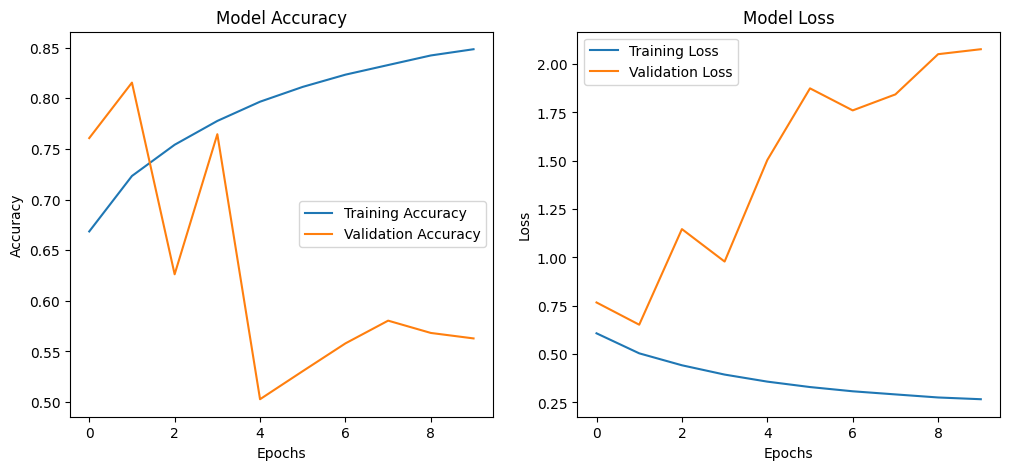

In [122]:

# Extract training history
history_dict = history.history

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict["accuracy"], label="Training Accuracy")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict["loss"], label="Training Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()


#### DNN_model

In [129]:
def build_DNN_model(sequence_length=60, no_features=10, num_classes=5):
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dense(sequence_length * 5),
        Reshape((sequence_length, 5)),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam',metrics=['accuracy'], loss='sparse_categorical_crossentropy')
    return model

In [130]:
DNN_model = build_DNN_model()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)  
]

history = DNN_model.fit(
    X_train_tensor,
    y_train_tensor,
    validation_split=0.1,
    epochs=10,
    verbose=1,
    batch_size=128,
    sample_weight=sample_weight,
    callbacks=callbacks
)
DNN_model.save("models/DNN_model.keras")

Epoch 1/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6645 - loss: 0.6556 - val_accuracy: 0.8468 - val_loss: 0.6070
Epoch 2/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7292 - loss: 0.5123 - val_accuracy: 0.8151 - val_loss: 0.6473
Epoch 3/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7448 - loss: 0.4832 - val_accuracy: 0.7607 - val_loss: 0.8249
Epoch 4/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7566 - loss: 0.4651 - val_accuracy: 0.5226 - val_loss: 2.0241
Epoch 5/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7685 - loss: 0.4467 - val_accuracy: 0.8352 - val_loss: 0.6790
Epoch 6/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7757 - loss: 0.4314 - val_accuracy: 0.8200 - val_loss: 0.7967
Epoch 7/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7817 - loss: 0.4225 - val_accuracy: 0.8574 - val_loss: 0.6190
Epoch 8/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7885 - loss: 0.4122 - 

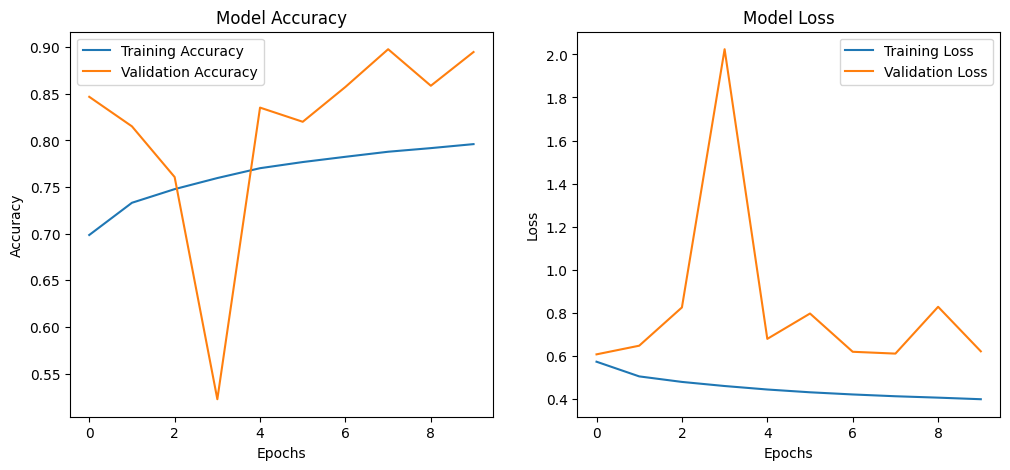

In [131]:

# Extract training history
history_dict = history.history

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict["accuracy"], label="Training Accuracy")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict["loss"], label="Training Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()

#### RNN_model

In [106]:
def build_RNN_model(sequence_length=60, no_features=10, num_classes=5):
    """
    Builds and returns an RNN model for air quality classification.
    
    Parameters:
    - sequence_length (int): Number of input/output timesteps (60)
    - no_features (int): Number of input features (10)
    - num_classes (int): Number of air quality categories (5)
    
    Returns:
    - model (Sequential): Compiled Keras model
    """
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        
        # Stacked LSTM layers with return_sequences=True
        LSTM(128, return_sequences=True, activation='tanh'),
        LSTM(64, return_sequences=True, activation='tanh'),
        
        # Final classification layers
        TimeDistributed(Dense(64, activation='relu')),
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])
    
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

In [132]:
RNN_model = build_RNN_model()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)  
]

history = RNN_model.fit(
    X_train_tensor,
    y_train_tensor,
    validation_split=0.1,
    epochs=10,
    verbose=1,
    batch_size=128,
    sample_weight=sample_weight,
    callbacks=callbacks
)
RNN_model.save("models/RNN_model.keras")

Epoch 1/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.6383 - loss: 0.6972 - val_accuracy: 0.8185 - val_loss: 1.2288
Epoch 2/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.7482 - loss: 0.4807 - val_accuracy: 0.7744 - val_loss: 1.4180
Epoch 3/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.8047 - loss: 0.3814 - val_accuracy: 0.6774 - val_loss: 1.5381
Epoch 4/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.8159 - loss: 0.3605 - val_accuracy: 0.7225 - val_loss: 1.7912
Epoch 5/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.8513 - loss: 0.2882 - val_accuracy: 0.7098 - val_loss: 1.9027
Epoch 6/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.8636 - loss: 0.2608 - val_accuracy: 0.7212 - val_loss: 2.0145
Epoch 7/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.8746 - loss: 0.2353 - val_accuracy: 0.7473 - val_loss: 2.0069
Epoch 8/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.8836 -

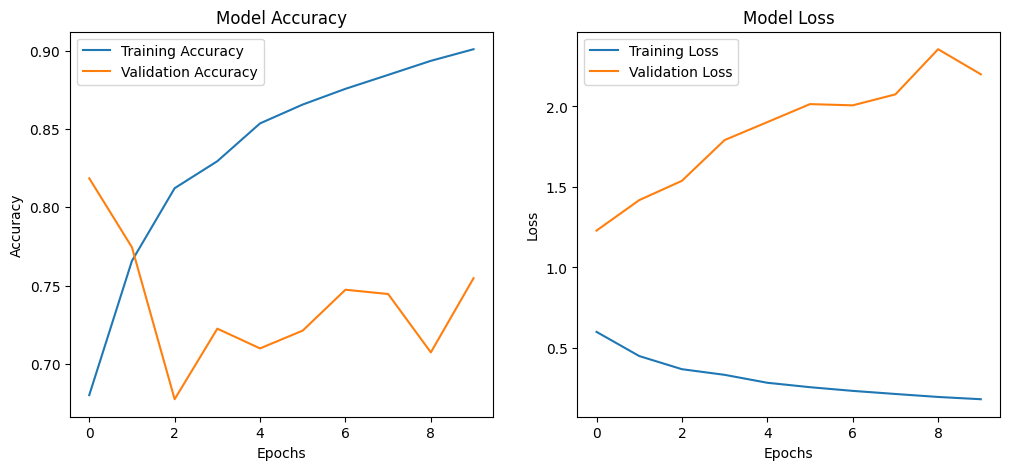

In [133]:

# Extract training history
history_dict = history.history

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict["accuracy"], label="Training Accuracy")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict["loss"], label="Training Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()

#### lstm_model

In [135]:
def build_lstm_model(sequence_length=60, no_features=10, num_classes=5):
    """
    Standard unidirectional LSTM model for sequence prediction.
    Processes sequences in forward direction only.
    """
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        
        # First LSTM layer
        LSTM(128, return_sequences=True, 
            dropout=0.2, recurrent_dropout=0.1),
        
        # Second LSTM layer
        LSTM(64, return_sequences=True),
        
        # Classification head
        TimeDistributed(Dense(64, activation='relu')),
        TimeDistributed(Dropout(0.2)),
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])
    
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model


In [136]:
lstm_model = build_lstm_model()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)  
]

history = lstm_model.fit(
    X_train_tensor,
    y_train_tensor,
    validation_split=0.1,
    epochs=10,
    verbose=1,
    batch_size=128,
    sample_weight=sample_weight,
    callbacks=callbacks
)

lstm_model.save("models/lstm_model.keras")

Epoch 1/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 141s 79ms/step - accuracy: 0.5599 - loss: 0.8654 - val_accuracy: 0.4908 - val_loss: 1.4172
Epoch 2/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 136s 81ms/step - accuracy: 0.6391 - loss: 0.6552 - val_accuracy: 0.3881 - val_loss: 1.9402
Epoch 3/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 136s 81ms/step - accuracy: 0.6588 - loss: 0.6190 - val_accuracy: 0.3218 - val_loss: 2.2038
Epoch 4/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 134s 80ms/step - accuracy: 0.6766 - loss: 0.5895 - val_accuracy: 0.2168 - val_loss: 3.3030
Epoch 5/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 132s 79ms/step - accuracy: 0.6886 - loss: 0.5657 - val_accuracy: 0.2564 - val_loss: 2.3044
Epoch 6/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 132s 79ms/step - accuracy: 0.6990 - loss: 0.5468 - val_accuracy: 0.3450 - val_loss: 2.1998
Epoch 7/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 132s 79ms/step - accuracy: 0.7076 - loss: 0.5342 - val_accuracy: 0.2503 - val_loss: 2.8747
Epoch 8/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 133s 79ms/step - accuracy: 

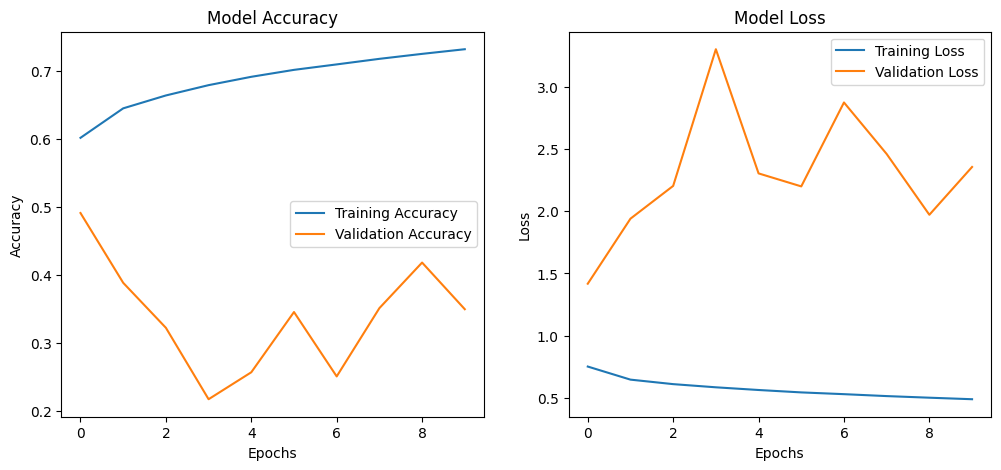

In [137]:

# Extract training history
history_dict = history.history

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict["accuracy"], label="Training Accuracy")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict["loss"], label="Training Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()


#### bilstm_model

In [138]:
def build_bilstm_model(sequence_length=60, no_features=10, num_classes=5):
    """
    Bidirectional LSTM model that processes sequences 
    in both forward and backward directions.
    """
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        
        # First BiLSTM layer
        Bidirectional(LSTM(64, return_sequences=True,
                          dropout=0.2, recurrent_dropout=0.1)),
        
        # Second BiLSTM layer
        Bidirectional(LSTM(32, return_sequences=True)),
        
        # Classification head
        TimeDistributed(Dense(64, activation='relu')),
        TimeDistributed(Dropout(0.2)),
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])
    
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model


In [139]:
bilstm_model = build_bilstm_model()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)  
]

history = bilstm_model.fit(
    X_train_tensor,
    y_train_tensor,
    validation_split=0.1,
    epochs=10,
    verbose=1,
    batch_size=128,
    sample_weight=sample_weight,
    callbacks=callbacks
)

bilstm_model.save("models/bilstm_model.keras")

Epoch 1/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 205s 116ms/step - accuracy: 0.5960 - loss: 0.7805 - val_accuracy: 0.5609 - val_loss: 1.5483
Epoch 2/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 199s 118ms/step - accuracy: 0.6876 - loss: 0.5805 - val_accuracy: 0.4962 - val_loss: 1.8793
Epoch 3/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 198s 118ms/step - accuracy: 0.7062 - loss: 0.5463 - val_accuracy: 0.7139 - val_loss: 1.2685
Epoch 4/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 193s 115ms/step - accuracy: 0.7186 - loss: 0.5247 - val_accuracy: 0.7779 - val_loss: 1.1946
Epoch 5/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 193s 115ms/step - accuracy: 0.7284 - loss: 0.5047 - val_accuracy: 0.6774 - val_loss: 1.3961
Epoch 6/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 193s 115ms/step - accuracy: 0.7357 - loss: 0.4918 - val_accuracy: 0.6913 - val_loss: 1.6273
Epoch 7/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 193s 115ms/step - accuracy: 0.7446 - loss: 0.4773 - val_accuracy: 0.6292 - val_loss: 1.9911
Epoch 8/10
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 194s 116ms/step - ac

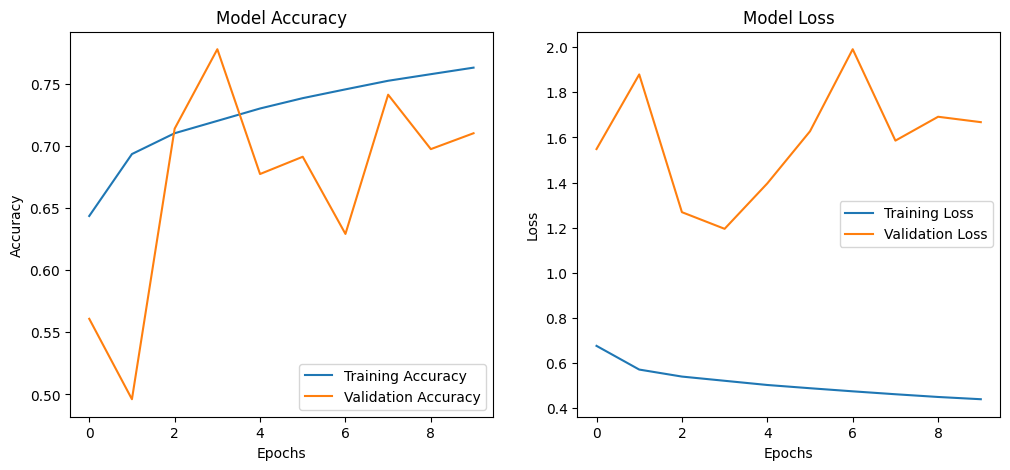

In [140]:

# Extract training history
history_dict = history.history

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict["accuracy"], label="Training Accuracy")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict["loss"], label="Training Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()


#### CNN_BILSTM

In [66]:
def build_CNN_BILSTM(sequence_length=60, no_features=10, num_classes=5):
    """
    CNN, BiLSTM
    """
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        
        # CNN Feature Extraction Block
        Conv1D(128, kernel_size=5, activation='relu', padding='causal'),
        BatchNormalization(),
        # MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        Conv1D(64, kernel_size=3, activation='relu', padding='causal'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Bidirectional LSTM Temporal Modeling
        Bidirectional(LSTM(64, return_sequences=True, 
                         dropout=0.2, recurrent_dropout=0.1)),
        Bidirectional(LSTM(32, return_sequences=True)),
        
        # Classification Head
        TimeDistributed(Dense(64, activation='relu')),
        TimeDistributed(Dropout(0.1)),
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])
    
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [67]:
CNN_BILSTM = build_CNN_BILSTM()
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)  
]

history = CNN_BILSTM.fit(
    X_train_tensor,
    y_train_tensor,
    validation_split=0.1,
    epochs=10,
    verbose=1,
    batch_size=128,
    sample_weight=sample_weight,
    callbacks=callbacks
)

CNN_BILSTM.save("models/CNN_BILSTM.keras")

2025-03-14 06:41:50.308628: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554688000 exceeds 10% of free system memory.
2025-03-14 06:41:50.402211: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 499219200 exceeds 10% of free system memory.


Epoch 1/10
 268/1626 ━━━━━━━━━━━━━━━━━━━━ 3:54 173ms/step - accuracy: 0.6249 - loss: 0.8461

KeyboardInterrupt: 

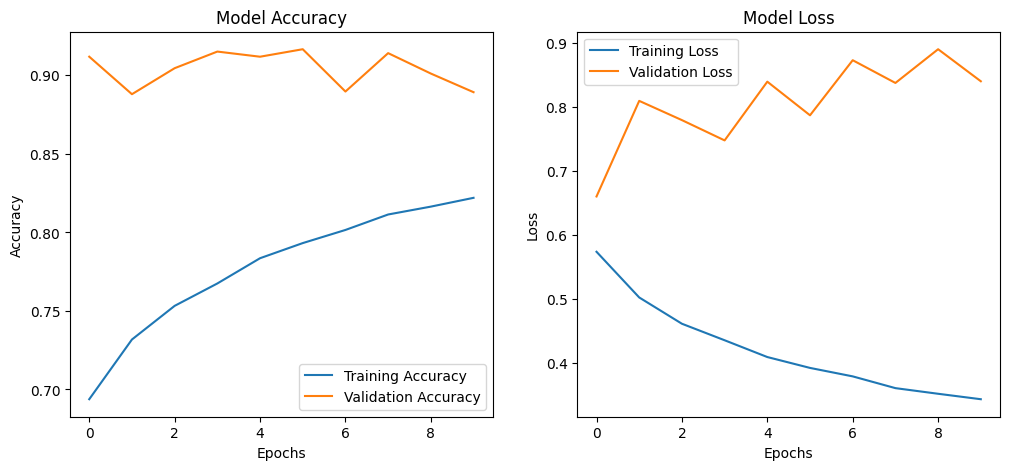

In [143]:

# Extract training history
history_dict = history.history

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict["accuracy"], label="Training Accuracy")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict["loss"], label="Training Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()


#### Evaluation

In [23]:
X_test_sequences, y_test_sequences = generate_sequences(X_test, y_test)

In [24]:
def evaluate_model(model, X_test_sequences, y_test_sequences, le):
    """
    Computes accuracy, precision, recall, F1-score, and confusion matrix for the entire test dataset.
    
    Parameters:
    - model: Trained model.
    - X_test_sequences: Test data sequences.
    - y_test_sequences: True labels.
    - le: Label encoder to transform labels back to original class names.
    
    Returns:
    - metrics (dict): Dictionary containing accuracy, precision, recall, F1-score, and confusion matrix.
    """
    predictions = model.predict(X_test_sequences)
    int_predictions = np.round(predictions).astype(int)
    
    # Convert one-hot encoded predictions to class indices
    class_indices = np.argmax(int_predictions, axis=-1).flatten()
    class_predictions = le.inverse_transform(class_indices)
    
    # Get real class labels
    class_real = le.inverse_transform(y_test_sequences.flatten())
    
    # Compute metrics
    acc = accuracy_score(class_real, class_predictions)
    prec = precision_score(class_real, class_predictions, average='weighted', zero_division=0)
    rec = recall_score(class_real, class_predictions, average='weighted', zero_division=0)
    f1 = f1_score(class_real, class_predictions, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(class_real, class_predictions)
    
    metrics = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Confusion Matrix': conf_matrix
    }
    
    return metrics

In [25]:
from tensorflow.keras.models import load_model

# Define model paths
model_paths = [
    "models/bilstm_model.keras",
    "models/DCNN_model.keras",
    "models/lstm_model.keras",
    "models/CNN_BILSTM.keras",
    "models/DNN_model.keras",
    "models/RNN_model.keras"
]

# Load models into a dictionary
models = {path.split("/")[-1]: load_model(path) for path in model_paths}

# Access models using their filenames
CNN_BILSTM = models["CNN_BILSTM.keras"]
bilstm_model = models["bilstm_model.keras"]
DCNN_model = models["DCNN_model.keras"]
lstm_model = models["lstm_model.keras"]
DNN_model = models["DNN_model.keras"]
RNN_model = models["RNN_model.keras"]


In [ ]:
# Example: Evaluate each model and store the results in a dictionary
models = {
    'bilstm_model': bilstm_model,
    'DCNN_model': DCNN_model,
    'lstm_model': lstm_model,
    'CNN_BILSTM': CNN_BILSTM,
    'DNN_model': DNN_model,
    'RNN_model': RNN_model
}

results_test = {}
results_train = {}  # if you have train evaluation results as well

for name, model in models.items():
    # Evaluate on test data
    results_test[name] = evaluate_model(model, X_test_sequences, y_test_sequences, le)
    # Evaluate on train data 
    results_train[name] = evaluate_model(model, X_train, y_train, le)


1863/1863 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step
  12/7461 ━━━━━━━━━━━━━━━━━━━━ 1:15 10ms/step

2025-03-13 20:41:53.937875: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 572990400 exceeds 10% of free system memory.


7461/7461 ━━━━━━━━━━━━━━━━━━━━ 73s 10ms/step


I0000 00:00:1741891505.525429  143654 service.cc:148] XLA service 0x7d72b00a1320 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741891505.525636  143654 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-03-13 20:45:05.585070: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  50/1863 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

I0000 00:00:1741891506.556940  143654 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1863/1863 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
  53/7461 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

2025-03-13 20:45:39.560816: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 572990400 exceeds 10% of free system memory.


7461/7461 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
1863/1863 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step
  12/7461 ━━━━━━━━━━━━━━━━━━━━ 1:15 10ms/step

2025-03-13 20:48:42.820308: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 572990400 exceeds 10% of free system memory.


7461/7461 ━━━━━━━━━━━━━━━━━━━━ 67s 9ms/step
1863/1863 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step
  12/7461 ━━━━━━━━━━━━━━━━━━━━ 1:19 11ms/step

2025-03-13 20:52:34.133253: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 572990400 exceeds 10% of free system memory.


7461/7461 ━━━━━━━━━━━━━━━━━━━━ 79s 11ms/step
1863/1863 ━━━━━━━━━━━━━━━━━━━━ 2s 966us/step
 159/7461 ━━━━━━━━━━━━━━━━━━━━ 6s 958us/step

2025-03-13 20:56:19.501704: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 572990400 exceeds 10% of free system memory.


7461/7461 ━━━━━━━━━━━━━━━━━━━━ 7s 898us/step
1863/1863 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step
7461/7461 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step


In [ ]:
# with open("History/results_test.pkl", "wb") as f:
#     pickle.dump(results_test, f)

# with open("History/results_train.pkl", "wb") as f:
#     pickle.dump(results_train, f)

In [45]:
with open("History/results_test.pkl", "rb") as f:
    results_test = pickle.load(f)

with open("History/results_train.pkl", "rb") as f:
    results_train = pickle.load(f)

In [30]:
# Extract model names and their corresponding test accuracies
model_names = list(results_test.keys())
accuracies = [metrics['Accuracy'] for metrics in [results_test[m] for m in model_names]]


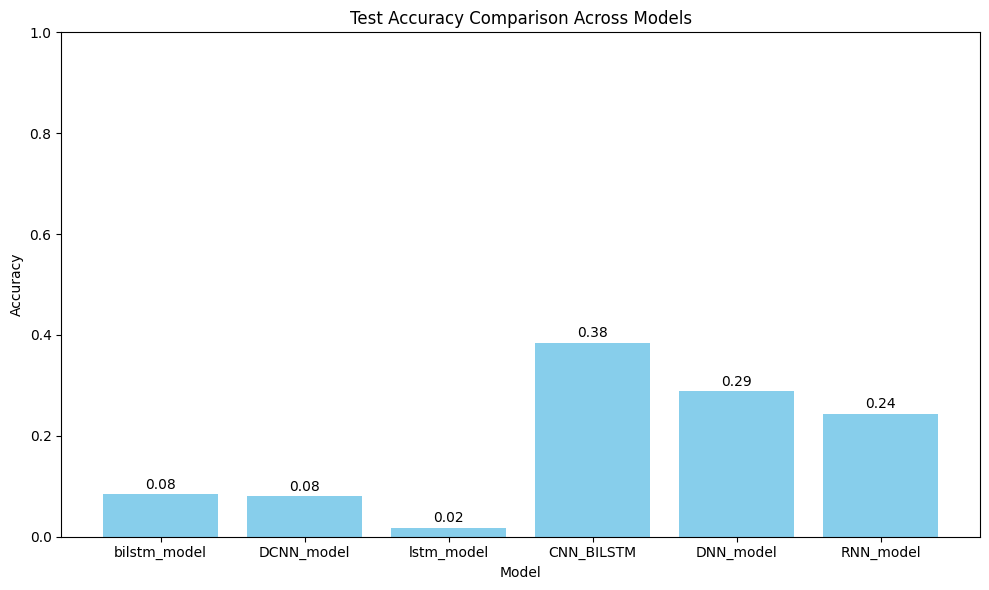

In [31]:
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison Across Models')
plt.ylim(0, 1)  # Assuming accuracy is a value between 0 and 1

# Adding text labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.005, f"{yval:.2f}", ha='center', va='bottom')

    
plt.tight_layout()
plt.show()


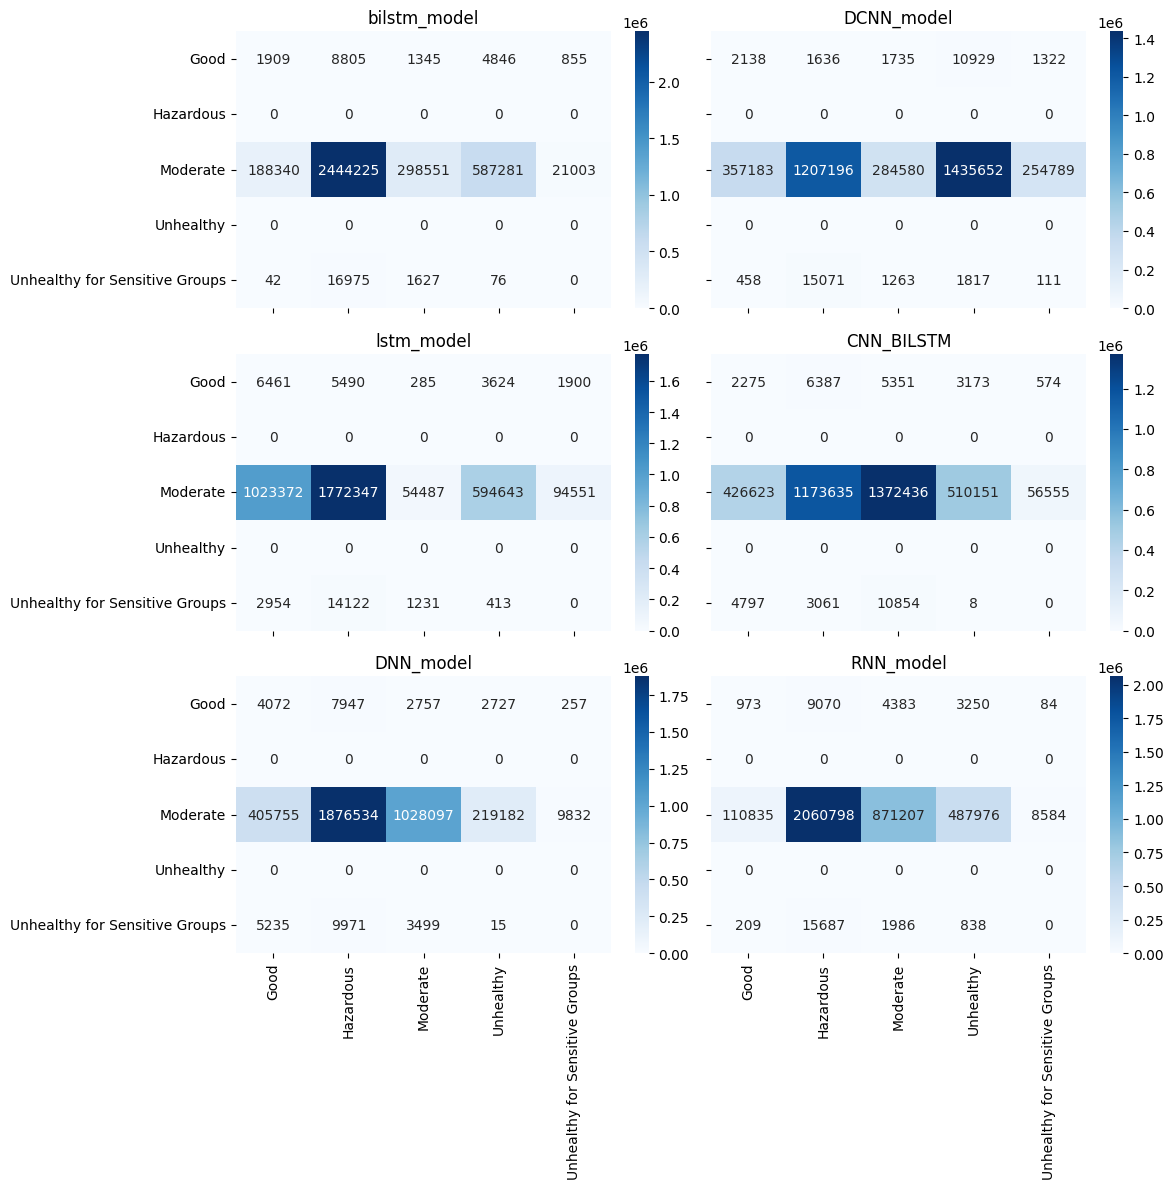

In [ ]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

n_models = len(model_names)
n_cols = 2
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten() 

class_labels = le.inverse_transform(range(len(le.classes_)))

for idx, m in enumerate(model_names):
    ax = axes[idx]
    cm = results_test[m]['Confusion Matrix']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_labels, yticklabels=class_labels)
    ax.set_title(m)
    

    if idx < n_models - n_cols:
        ax.set_xticklabels([])
    if idx % n_cols != 0:
        ax.set_yticklabels([])

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [41]:
model_names = ['bilstm_model', 'DCNN_model', 'lstm_model', 'CNN_BILSTM', 'DNN_model', 'RNN_model']

# For test accuracies (assuming all are present)
test_accuracies = [results_test[model]['Accuracy'] for model in model_names]

# For training accuracies, use .get() to avoid KeyError if a model is missing
train_accuracies = []
for model in model_names:
    model_metrics = results_train.get(model)
    if model_metrics is None:
        print(f"Warning: Training results for '{model}' not found.")
        train_accuracies.append(0)  # or use None, or skip it
    else:
        train_accuracies.append(model_metrics.get('Accuracy', 0))


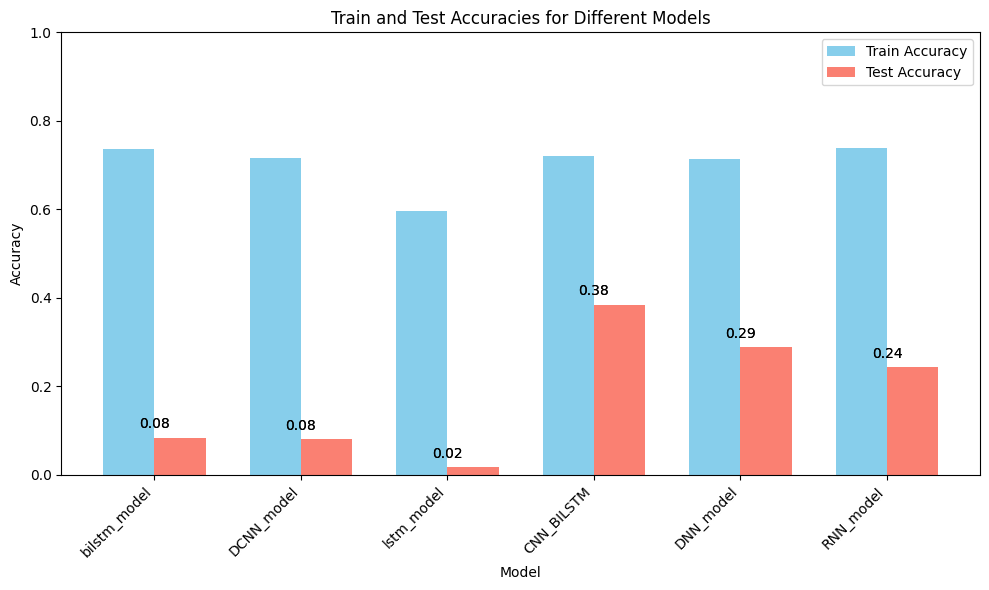

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Example model names and corresponding accuracies
model_names = ['bilstm_model', 'DCNN_model', 'lstm_model', 'CNN_BILSTM', 'DNN_model', 'RNN_model']
test_accuracies = [results_test[model]['Accuracy'] for model in model_names]
train_accuracies = [results_train[model]['Accuracy'] for model in model_names]

# Set positions and width for the bars
x = np.arange(len(model_names))
width = 0.35  # width of each bar

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy', color='skyblue')
bars2 = plt.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='salmon')

# Adding labels, title, and custom x-axis tick labels
ax = plt.gca()  # get current axes
ax.set_ylabel('Accuracy')
ax.set_title('Train and Test Accuracies by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim(0, 1)
ax.legend()

# Annotate each bar with its accuracy value
def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Call the function for both sets of bars
for bars_set in [bars2, bars1]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height + 0.005),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Alternatively, annotate each set separately:
# for bar in bars:
#     height = bar.get_height()
#     ax.annotate(f'{height:.2f}',
#                 xy=(bar.get_x() + bar.get_width() / 2, height),
#                 xytext=(0, 3),
#                 textcoords="offset points",
#                 ha='center', va='bottom')

plt.ylim(0, 1)
plt.title('Train and Test Accuracies for Different Models')
plt.xticks(x, model_names, rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()




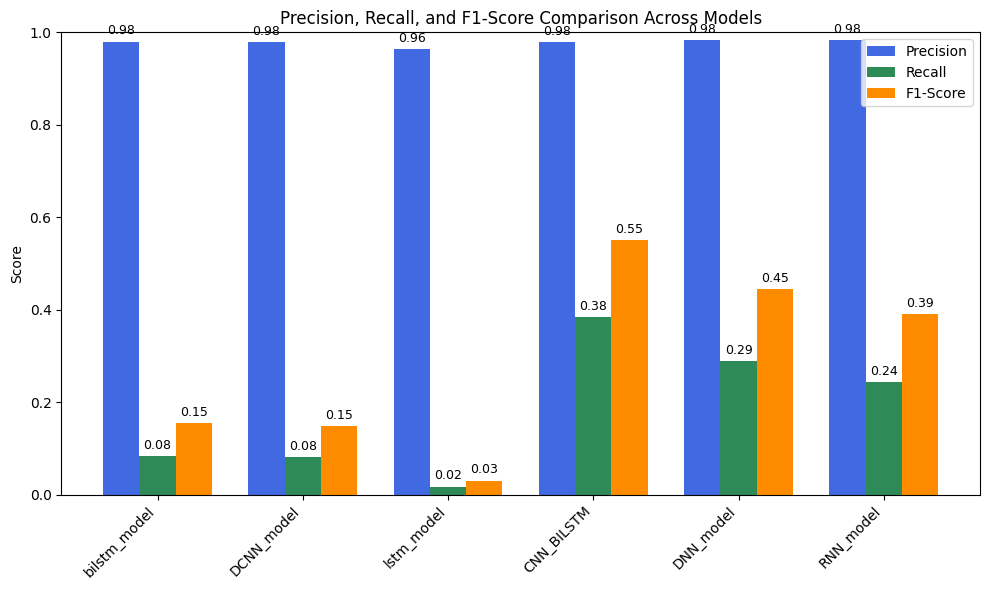

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names
model_names = ['bilstm_model', 'DCNN_model', 'lstm_model', 'CNN_BILSTM', 'DNN_model', 'RNN_model']

# Extract Precision, Recall, and F1-Score for each model from results_test
precisions = [results_test[model]['Precision'] for model in model_names]
recalls = [results_test[model]['Recall'] for model in model_names]
f1_scores = [results_test[model]['F1-Score'] for model in model_names]

# Define positions and width for the bars
x = np.arange(len(model_names))  # Position of each model
width = 0.25  # Width of each bar

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for Precision, Recall, and F1-Score
bars1 = ax.bar(x - width, precisions, width, label='Precision', color='royalblue')
bars2 = ax.bar(x, recalls, width, label='Recall', color='seagreen')
bars3 = ax.bar(x + width, f1_scores, width, label='F1-Score', color='darkorange')

# Add labels, title, and customize x-axis
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1-Score Comparison Across Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim(0, 1)  # Since Precision, Recall, and F1-Score are between 0 and 1
ax.legend()

# Function to annotate bars with values
def autolabel(bars):
    """Attach a text label above each bar displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", 
                    ha='center', va='bottom', fontsize=9)

# Apply annotation function to each set of bars
for bars in [bars1, bars2, bars3]:
    autolabel(bars)

# Show plot
plt.tight_layout()
plt.show()


#### Optimization 

- implement Progressive Layer Freezing and Low-Rank Factorization

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Bidirectional, LSTM, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping

def build_optimized_model(sequence_length=60, no_features=10, num_classes=5):
    """Model with Low-Rank Factorization and Progressive Freezing support"""
    model = Sequential([
        Input(shape=(sequence_length, no_features)),
        
        # CNN Block
        Conv1D(128, 5, activation='relu', padding='causal'),
        BatchNormalization(),
        Dropout(0.3),
        
        Conv1D(64, 3, activation='relu', padding='causal'),
        BatchNormalization(),
        Dropout(0.2),
        
        # BiLSTM Block
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)),
        Bidirectional(LSTM(32, return_sequences=True)),
        
        # Classification Head with Low-Rank Factorization
        TimeDistributed(Dense(32, use_bias=False)),  # Reduced from 64
        TimeDistributed(Dense(64, activation='relu')),
        Dropout(0.1),
        TimeDistributed(Dense(16, use_bias=False)),  # Reduced from 5
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])
    
    return model

# Load your pretrained model (optional)
# base_model = load_model('models/CNN_BILSTM.keras')

# Build new optimized model
optimized_model = build_optimized_model()
optimized_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

class ProgressiveFreezer(tf.keras.callbacks.Callback):
    """Implements Progressive Layer Freezing"""
    def __init__(self, unfreeze_stages):
        super().__init__()
        self.stages = unfreeze_stages  # List of epoch numbers to unfreeze next stage
        self.current_stage = 0
        
    def on_epoch_begin(self, epoch, logs=None):
        if self.current_stage < len(self.stages) and epoch >= self.stages[self.current_stage]:
            print(f"\nUnfreezing stage {self.current_stage+1} layers")
            self._unfreeze_next_stage()
            self.current_stage += 1
            self.model.compile(optimizer=self.model.optimizer,
                             loss=self.model.loss,
                             metrics=self.model.metrics)
            
    def _unfreeze_next_stage(self):
        # Stage 0: Freeze all except classifier
        # Stage 1: Unfreeze BiLSTM layers
        # Stage 2: Unfreeze CNN layers
        
        if self.current_stage == 0:
            for layer in self.model.layers:
                if 'bidirectional' in layer.name:
                    layer.trainable = True
        elif self.current_stage == 1:
            for layer in self.model.layers:
                if 'conv1d' in layer.name:
                    layer.trainable = True

# Freeze all layers initially except classifier
for layer in optimized_model.layers[:-4]:  # Freeze everything except last 4 layers
    layer.trainable = False

# Training configuration
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ProgressiveFreezer(unfreeze_stages=[5, 10])  # Unfreeze BiLSTM at epoch 5, CNN at 10
]

history = optimized_model.fit(
    X_train_tensor,
    y_train_tensor,
    validation_split=0.1,
    epochs=2,  # Total epochs should cover all unfreeze stages
    verbose=1,
    batch_size=128,
    sample_weight=sample_weight,
    callbacks=callbacks
)

Epoch 1/2
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 142s 80ms/step - accuracy: 0.3326 - loss: 1.3432 - val_accuracy: 0.7714 - val_loss: 0.6535
Epoch 2/2
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 133s 79ms/step - accuracy: 0.4567 - loss: 1.1115 - val_accuracy: 0.7925 - val_loss: 0.6225
